In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [167]:
from utils import import_data, correlation_matrix, compute_KNN_graph, create_graph, create_batch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'} 

In [168]:
print(torch.__version__)

1.13.1


In [169]:
print(torch_geometric.__version__)

2.1.0


In [170]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17954)])
df = df.dropna(axis=0, subset=['Gender'])

# Real test set
TEST =  df.iloc[-30:]

df = df.iloc[:-30]

# Labels
y = (df.Gender).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])

#X = (df.iloc[:,:-3])

In [171]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.37% 
 1 = 0.63%


In [172]:
from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, shuffle=True, random_state=42)

In [173]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_test, y_test)

# Make predictions on the testing data
pred_y = dummy.predict(X_test)

scores = cross_validate(dummy, X, y, cv=5, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

Accuracy in test:0.63(0.00)
F1_scores 0.39(0.00)
Precision_scores 0.31(0.00)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [174]:
A = correlation_matrix(190,X_train.iloc[-1])


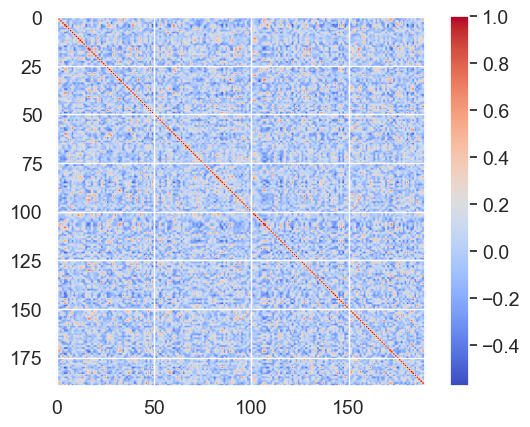

In [175]:
plt.imshow(A)
plt.colorbar()
plt.show()

## K-NN for selecting edges

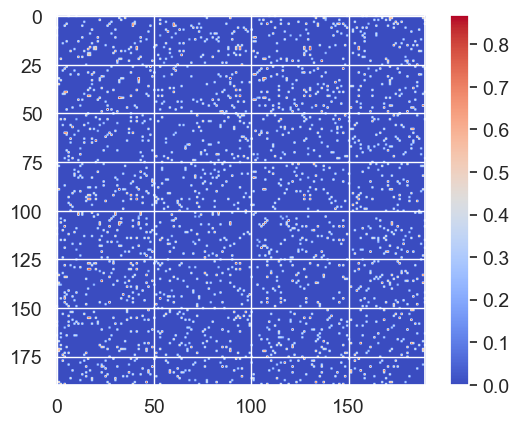

In [176]:
plt.imshow(np.array(compute_KNN_graph(A, 10)))
plt.colorbar()
plt.show()

## Creating the graphs

In [177]:
train_data, val_data = create_graph(X_train, X_test, y_train, y_test)

In [178]:
print(train_data[0])

Data(x=[190, 190], edge_index=[2, 3550], edge_attr=[3550, 1], y=0)


In [179]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)


In [180]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.6):
        super(GCN, self).__init__()

        self.p = dropout
        
        self.conv1 = GCNConv(int(num_features), 64)
        self.conv2 = GCNConv(64, 32)
        
        #self.conv3 = GCNConv(16, 2)
        
        #self.conv1 = ChebConv(int(num_features), 128, K=k_order)
        #self.conv2 = ChebConv(128, 32, K=k_order)
        #self.conv3 = ChebConv(64, 32, K=k_order)

        self.lin1 = torch.nn.Linear(32, int(num_classes))
        
        #self.max = torch.nn.Softmax(dim=1)
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        
        x = func.relu(self.conv1(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        x = func.dropout(x, p=self.p, training=self.training)
        x = func.relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        x = func.dropout(x, p=self.p, training=self.training)
        # x = func.relu(self.conv3(x, edge_index))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        # x = func.dropout(x, p=self.p, training=self.training)
        
        x = self.pool(x, batch)
        x = self.lin1(x)
        x = func.dropout(x, p=self.p, training=self.training)
        
        return x

# Testing in one fold

In [148]:
def GCN_train(loader, loop):
    model.train()
    l1_weight = 1e-5
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)
        #print(output)
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, y.y)
        loss_with_penalty = loss + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all)
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
        
    return epoch_acc, loss_all / len(train_data)


def GCN_test(loader):
    test_metrics = pd.DataFrame()
    
    model.eval()
    l1_weight = 1e-5
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_sen = tp / (tp + fn)
    epoch_spe = tn / (tn + fp)
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return epoch_sen, epoch_spe, epoch_acc, loss_all / len(val_data), roc_auc


In [155]:
metrics = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
   
min_v_loss = np.inf  

NUM_EPOCHS = 50
for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_acc, train_loss = GCN_train(train_loader,loop)
    test_sen, test_spe, test_acc, test_loss, roc_auc = GCN_test(val_loader)
    
    metrics['loss_train'].append(train_loss)
    metrics['loss_test'].append(test_loss)
    metrics['acc_test'].append(test_acc)
    metrics['acc_train'].append(train_acc)

    

Epoch [1/50]: 100%|███████████████████| 20/20 [00:04<00:00,  4.59it/s, loss=440]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [2/50]: 100%|███████████████████| 20/20 [00:03<00:00,  5.76it/s, loss=428]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [3/50]: 100%|███████████████████| 20/20 [00:01<00:00, 10.91it/s, loss=421]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [4/50]: 100%|███████████████████| 20/20 [00:01<00:00, 13.72it/s, loss=423]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (t

### Debug

In [156]:
model.eval()

GCN(
  (conv1): GCNConv(190, 64)
  (conv2): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
)

In [157]:
y_pred = []
for y in val_loader:
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(func.softmax(model(y), dim=1).detach().numpy())#.max(dim=1)[1])

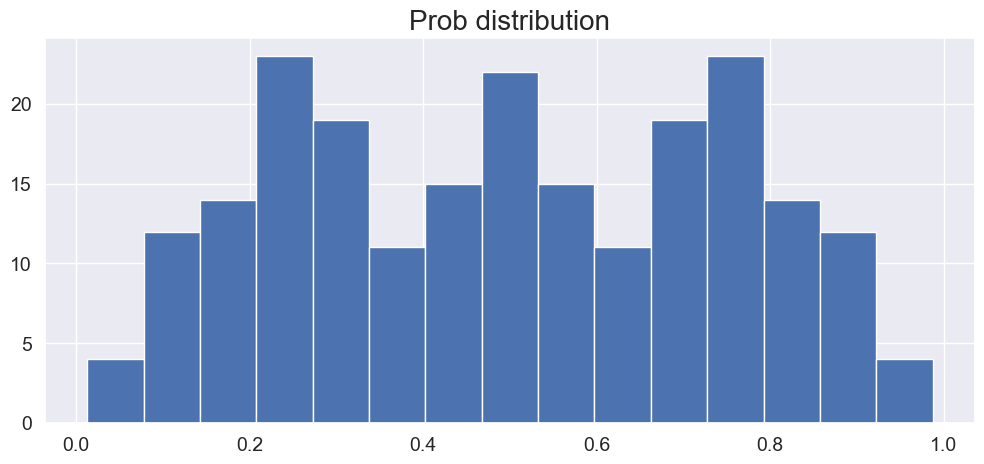

In [158]:
plt.figure(figsize=(12,5))
plt.hist(np.array(y_pred).reshape(len(y_pred)*2), bins=15)
plt.title("Prob distribution")
plt.show()

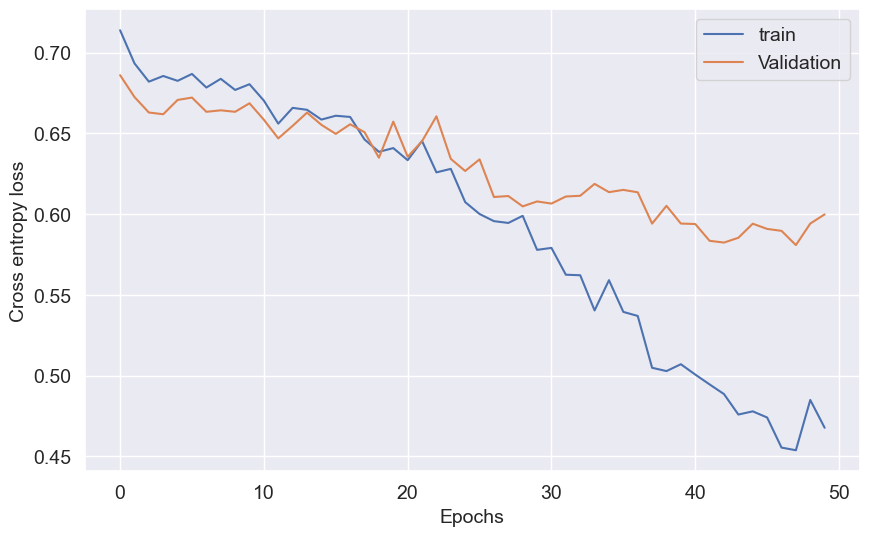

In [159]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Cross entropy loss')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()

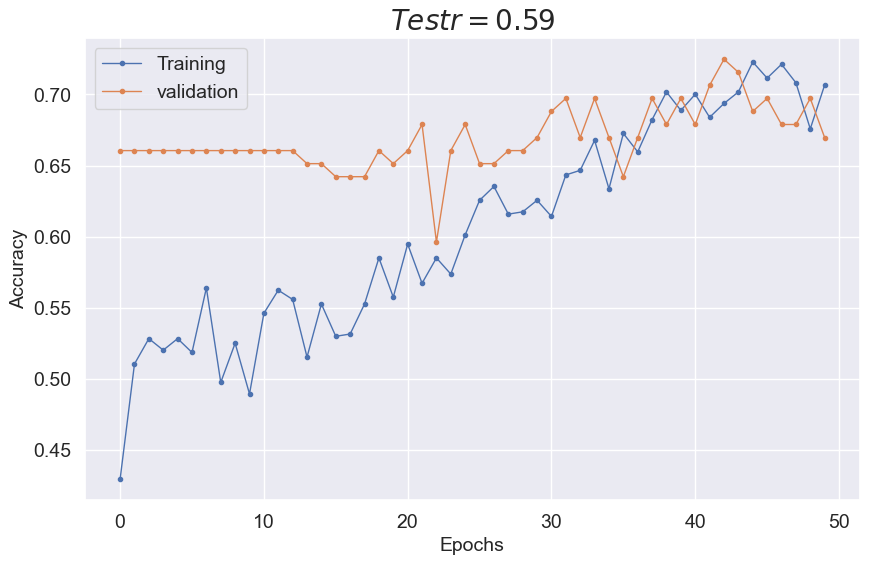

In [160]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['acc_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['acc_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['acc_test'])), metrics['acc_test'])[0][1]))
ax.legend()
plt.show()


## Cross validation

In [181]:
from sklearn.model_selection import KFold

inputs = X
targets = y

eval_scores = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

scores = np.zeros((5,5))
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    # creating the graphs
    train_data, val_data = create_graph(X.iloc[train], X.iloc[test],
                                         y.iloc[train], y.iloc[test])
    
    # creating the batchs inside the torch DataLoader
    train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    # Train the NN Archithecture
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(190, 2, 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

    min_v_loss = np.inf  

    NUM_EPOCHS = 50
    for epoch in range(1,NUM_EPOCHS + 1):
        loop = tqdm(train_loader)
        train_acc, train_loss = GCN_train(train_loader,loop)
        test_sen, test_spe, test_acc, test_loss, roc_auc = GCN_test(val_loader)
    

        eval_scores['loss_train'].append(train_loss)
        eval_scores['loss_test'].append(test_loss)
        eval_scores['acc_test'].append(test_acc)
        eval_scores['acc_train'].append(train_acc)

    
    scores[0][fold_no - 1] = test_acc
    scores[1][fold_no - 1] = test_sen
    scores[2][fold_no - 1] = test_spe
    scores[3][fold_no - 1] = test_loss
    scores[4][fold_no - 1] = roc_auc

    print(f'Score for fold {fold_no}: loss of {_}; acc of {test_acc}%; AUC of {roc_auc}%')

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...


Epoch [1/50]: 100%|███████████████████| 19/19 [00:00<00:00, 19.86it/s, loss=398]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [2/50]: 100%|███████████████████| 19/19 [00:00<00:00, 21.50it/s, loss=401]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [3/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.60it/s, loss=394]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [4/50]: 100%|███████████████████| 19/19 [00:00<00:00, 21.27it/s, loss=400]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (t

Score for fold 1: loss of GCN(
  (conv1): GCNConv(190, 64)
  (conv2): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
); acc of 0.6712328767123288%; AUC of 0.6031968031968031%
------------------------------------------------------------------------
Training for fold 2 ...


Epoch [1/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.07it/s, loss=404]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [2/50]: 100%|███████████████████| 19/19 [00:00<00:00, 21.03it/s, loss=398]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [3/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.99it/s, loss=401]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [4/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.95it/s, loss=396]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (t

Score for fold 2: loss of GCN(
  (conv1): GCNConv(190, 64)
  (conv2): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
); acc of 0.6620689655172414%; AUC of 0.6149022108843537%
------------------------------------------------------------------------
Training for fold 3 ...


Epoch [1/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.36it/s, loss=404]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [2/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.94it/s, loss=399]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [3/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.76it/s, loss=396]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [4/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.05it/s, loss=395]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (t

Score for fold 3: loss of GCN(
  (conv1): GCNConv(190, 64)
  (conv2): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
); acc of 0.6689655172413793%; AUC of 0.663793103448276%
------------------------------------------------------------------------
Training for fold 4 ...


Epoch [1/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.70it/s, loss=404]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [2/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.62it/s, loss=397]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [3/50]: 100%|███████████████████| 19/19 [00:00<00:00, 21.10it/s, loss=397]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [4/50]: 100%|███████████████████| 19/19 [00:00<00:00, 21.16it/s, loss=397]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (t

Score for fold 4: loss of GCN(
  (conv1): GCNConv(190, 64)
  (conv2): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
); acc of 0.6551724137931034%; AUC of 0.6396468699839486%
------------------------------------------------------------------------
Training for fold 5 ...


Epoch [2/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.80it/s, loss=392]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [3/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.82it/s, loss=399]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [4/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.65it/s, loss=395]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [5/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.76it/s, loss=395]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_22384/3245800988.py:59: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (t

Score for fold 5: loss of GCN(
  (conv1): GCNConv(190, 64)
  (conv2): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
); acc of 0.696551724137931%; AUC of 0.6808859721082855%


In [182]:
print('Average Accuracy in CV: {:.2f}({:.2f}) \n'.format(scores[0].mean(), scores[0].std()))
print('Average Sensitivity in CV: {:.2f}({:.2f}) \n'.format(scores[1].mean(), scores[1].std()))
print('Average Specificity in CV: {:.2f}({:.2f}) \n'.format(scores[2].mean(), scores[2].std()))
print('Average Loss in test CV: {:.2f}({:.2f}) \n'.format(scores[3].mean(), scores[3].std()))
print('Average AUC in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))

Average Accuracy in CV: 0.67(0.01) 

Average Sensitivity in CV: 0.73(0.03) 

Average Specificity in CV: 0.57(0.04) 

Average Loss in test CV: 0.62(0.02) 

Average AUC in test CV: 0.64(0.03) 



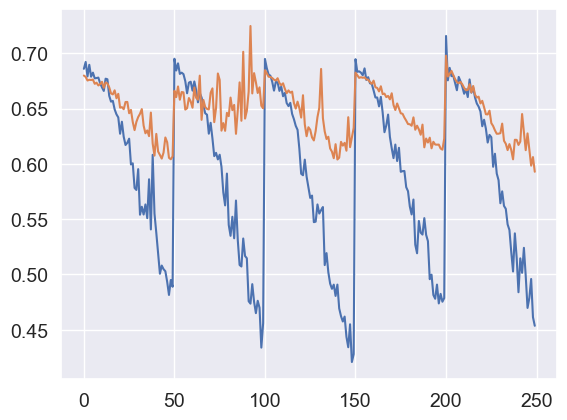

In [183]:
plt.plot(eval_scores['loss_train'])
plt.plot(eval_scores['loss_test'])

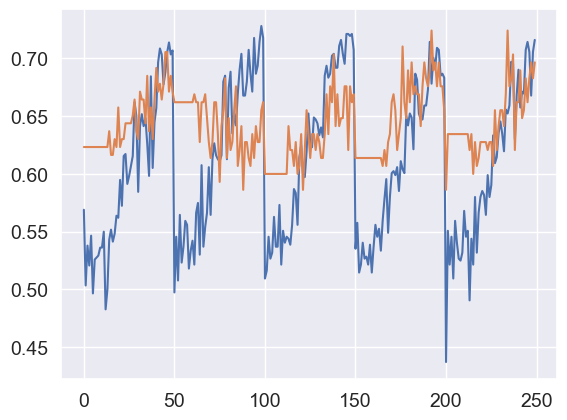

In [184]:
plt.plot(eval_scores['acc_train'])
plt.plot(eval_scores['acc_test'])

In [30]:
pd.DataFrame(scores.T, columns=['test_acc', 'test_prec_macro',
                                'test_rec_macro', 'test_f1',
                                'test_roc_auc']).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/GCN.csv')